<a href="https://colab.research.google.com/github/akankshaM29/OIBSIP/blob/main/detecting_human_emotions_yolov5_efnet_b0_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Realtime human emotions detection using YOLOv5 and Efficientnet b0!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


MessageError: Error: credential propagation was unsuccessful

#### Welcome to my notebook. It's made of 3 main parts: training Efficientnet b0 to distinguish emotions on human faces, training YOLOv5 to detect faces and validating the results.

![image.png](attachment:f076c1fc-fdd8-4302-8c67-0ec8bd87bd19.png)

## Video of final outcome:
https://vimeo.com/764615727/831033690e

---------

In [ ]:
pip install torchmetrics

In [ ]:
pip install torchvision

In [ ]:
pip install mlxtend

In [ ]:
pip install numba

In [ ]:
pip install gputil

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=ce68f7983ecdaf8fb5c3c39cc55e3377a28d76a8bde992fb773876ceec57b887
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [ ]:
pip install git+https://github.com/jfilter/split-folders.git

  Cloning https://github.com/jfilter/split-folders.git to /tmp/pip-req-build-i1cto7tk
  Running command git clone --filter=blob:none --quiet https://github.com/jfilter/split-folders.git /tmp/pip-req-build-i1cto7tk
  Resolved https://github.com/jfilter/split-folders.git to commit c566dbd56a1097e1ddba2de5dfb93bd67eade54f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for split_folders: filename=split_folders-0.5.1-py3-none-any.whl size=8400 sha256=f3dc1731ee9c30e8c5f9656aca06788a6c0c09cdf568b7051e01e678cff8f910
  Stored in directory: /tmp/pip-ephem-wheel-cache-qlqsukuu/wheels/0c/da/06/fcebe493adfe604ee9a1d4511e3932a6e63a044edb7a10dec8
Successfully built split_folders


In [ ]:
pip install torchinfo

In [ ]:
import requests
from zipfile import ZipFile
from pathlib import Path

import os
import glob

import random as random
from PIL import Image

import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from torchvision import datasets
from torchvision import transforms

import torchmetrics
import mlxtend

import matplotlib.pyplot as plt

from typing import Tuple
from typing import Dict
from typing import List
from timeit import default_timer as timer
from matplotlib import patches as mpatches

from tqdm.auto import tqdm

import gc

from numba import cuda

from GPUtil import showUtilization as gpu_usage

import splitfolders

from torchinfo import summary

import shutil

import numpy as np
import pandas as pd
import yaml

from os import listdir
from os.path import isfile, join

# 1. Training Efficientnet B0 to detect face emotions

## 1.1. Get the data

### Data extraction

In [ ]:
def extract_data(zipfile_path: Path, im: Path) -> None:
    '''Extracts zipfile'''

    if images_path.is_dir():
        print(f"{images_path} exists.")
    else:
        print(f"{images_path} doesn't exist, creating one...")
        images_path.mkdir(parents=True, exist_ok=True)

    if not os.listdir(images_path):
        with ZipFile(zipfile_path, 'r') as zip:
            print("Extracting files...")
            zip.extractall(images_path)

            print("Extracting finished.")
    else:
        print("Data already extracted.")

zipfile_path = Path("/content/drive/MyDrive/face emo dataset/archive.zip")
images_path = Path("/content/drive/MyDrive/face emo dataset/Dataset")

extract_data(zipfile_path, images_path)

/content/drive/MyDrive/face emo dataset/Dataset exists.
Data already extracted.


## Directory exploration
walk_through_dir prints the contents of our dataset

print_random_image prints one randomly chosen image from the whole dataset

In [ ]:
import os
from pathlib import Path
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} images in '{dirpath}' folder ")


walk_through_dir(images_path)

There are 2 directiories and 0 images in '/content/drive/MyDrive/face emo dataset/Dataset' folder 
There are 7 directiories and 0 images in '/content/drive/MyDrive/face emo dataset/Dataset/test' folder 
There are 0 directiories and 958 images in '/content/drive/MyDrive/face emo dataset/Dataset/test/angry' folder 
There are 0 directiories and 111 images in '/content/drive/MyDrive/face emo dataset/Dataset/test/disgust' folder 
There are 0 directiories and 1024 images in '/content/drive/MyDrive/face emo dataset/Dataset/test/fear' folder 
There are 0 directiories and 1774 images in '/content/drive/MyDrive/face emo dataset/Dataset/test/happy' folder 
There are 0 directiories and 1233 images in '/content/drive/MyDrive/face emo dataset/Dataset/test/neutral' folder 
There are 0 directiories and 1247 images in '/content/drive/MyDrive/face emo dataset/Dataset/test/sad' folder 
There are 0 directiories and 831 images in '/content/drive/MyDrive/face emo dataset/Dataset/test/surprise' folder 
There

Random image path: /content/drive/MyDrive/face emo dataset/Dataset/train/neutral/Training_25369440.jpg
Random image class: neutral
Image height: 48
Image width: 48


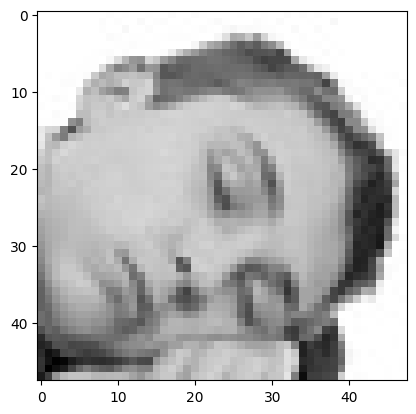

In [ ]:
%matplotlib inline

def print_random_image(images_path: list, seed=None) -> None:
    """Prints one random photo with details such as class, heigh, width"""
    if seed:
        random.seed(seed)

    random_image_path = random.choice(images_path)
    image_class = random_image_path.parent.stem
    image = Image.open(random_image_path)
    print(f"Random image path: {random_image_path}")
    print(f"Random image class: {image_class}")
    print(f"Image height: {image.height}")
    print(f"Image width: {image.width}")
    plt.imshow(image.convert('P'))


image_path_list = list(images_path.glob("*/*/*"))
print_random_image(image_path_list)

## 1.2. Define transforms for train and validation data

In [ ]:
train_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)),
     transforms.ToTensor()]
)

val_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)),
     transforms.ToTensor()]
)

## Visualize tranformations
Print a bunch of transformed images. All the images have been resized to (224x224) and they have 3 color channels.

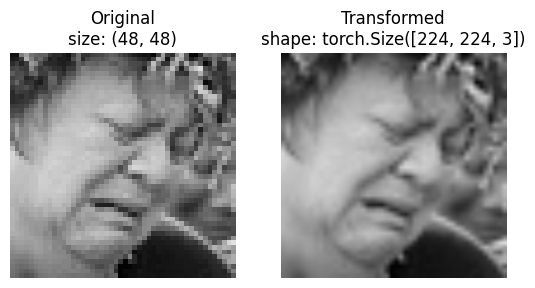

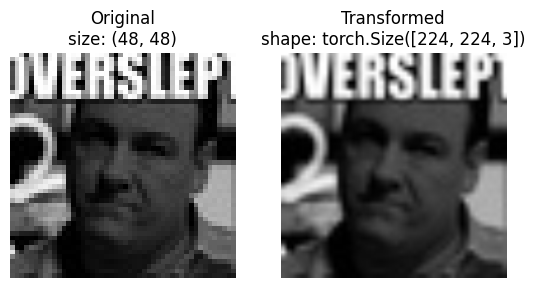

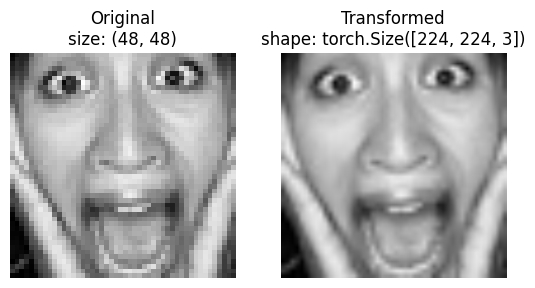

In [ ]:
def plot_transformed_images(images_path: Path,
                            transform: transforms,
                            n: int=3,
                            seed=None) -> None:
    """Selects random images from a path, transforms them and plots original vs transform"""
    if seed:
        random.seed(seed)

    if n > 10:
        print("n shouldn't be higher than 10 due to the size of displayed plot, changing n to 10")
        n = 10

    random_image_paths = random.sample(images_path, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path).convert('RGB') as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nsize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nshape: {transformed_image.shape}")
            ax[1].axis(False)


plot_transformed_images(image_path_list, train_transform)

## 1.3. Prepare the data
Save the data as two datasets that contain photos from train_dir and val_dir with applied transformations.

In [ ]:
train_dir = images_path / "train"
val_dir = images_path / "test"

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

val_data = datasets.ImageFolder(
    root=val_dir,
    transform=val_transform
)

## 1.4. Set the dataloaders
To make train data more random set the shuffle to True.
Print the shapes to see if we got the [B, C, H, W] configuration

In [ ]:
BATCH_SIZE = 8

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(torch.Size([8, 3, 224, 224]), torch.Size([8]))

## 1.5. Prepare the model
Define the weights and transforms for the VGG16 model.

Set the device.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Visualize the model
By default all the layers of the model are trainable. Let's freeze the features so model doesn't learn new patterns.

Classifier should stay trainable with output reduces to the amount of classes we predict.

In [ ]:
BATCH_SIZE = 16
model = torchvision.models.efficientnet_b0().to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 1000]           --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]   [16, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [16, 32, 112, 112]   [16, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 32, 112, 112]   [16, 16, 112

In [ ]:
output_shape = len(train_data.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 7]              --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]   [16, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [16, 32, 112, 112]   [16, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 32, 112, 112]   [16, 16, 112

## 1.6. Prepare the training
Define training and validation loop

In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device) -> Tuple[float, float, torch.Tensor]:

    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = torch.argmax(val_pred_logits, dim=1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))
            y_preds.append(val_pred_labels.cpu())

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    y_pred_tensor = torch.cat(y_preds)

    return val_loss, val_acc, y_pred_tensor


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device) -> Tuple[Dict, torch.Tensor]:

    results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "val_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        val_loss, val_acc, y_preds = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results, y_preds

## Run the model!

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.01
)

start_time = timer()

model_results, preds = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device
)

end_time = timer()
print(f"Total learning time: {(end_time - start_time):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, Train loss: 1.787, Train acc: 0.263, Val loss: 2.079, Val acc: 0.335
Epoch: 1, Train loss: 1.539, Train acc: 0.400, Val loss: 1.360, Val acc: 0.480
Epoch: 2, Train loss: 1.354, Train acc: 0.484, Val loss: 1.214, Val acc: 0.543
Epoch: 3, Train loss: 1.251, Train acc: 0.525, Val loss: 1.150, Val acc: 0.564
Epoch: 4, Train loss: 1.174, Train acc: 0.557, Val loss: 1.084, Val acc: 0.595
Epoch: 5, Train loss: 1.112, Train acc: 0.582, Val loss: 1.058, Val acc: 0.594
Epoch: 6, Train loss: 1.056, Train acc: 0.604, Val loss: 1.057, Val acc: 0.607
Epoch: 7, Train loss: 0.998, Train acc: 0.627, Val loss: 1.074, Val acc: 0.607
Epoch: 8, Train loss: 0.952, Train acc: 0.648, Val loss: 1.068, Val acc: 0.616
Epoch: 9, Train loss: 0.906, Train acc: 0.664, Val loss: 1.028, Val acc: 0.622
Total learning time: 2949.386


## 1.7. Visualize the training results.

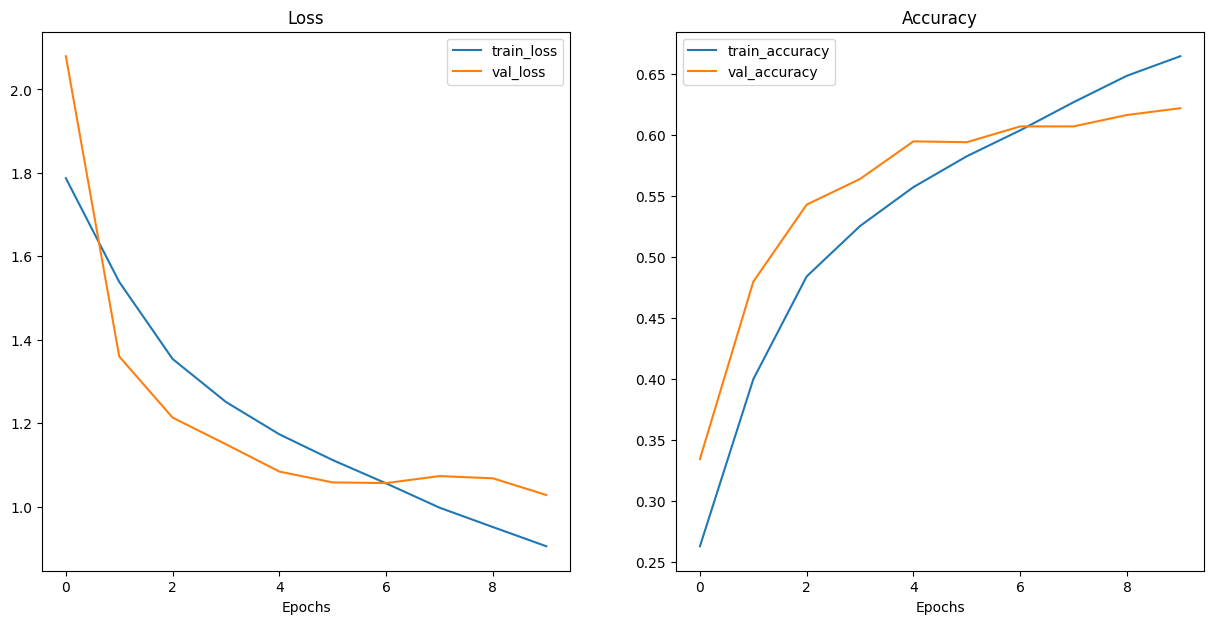

In [ ]:
def plot_curves(results: Dict[str, List[float]]) -> None:
    """Plots loss and accuracy from a results dictionary."""

    train_loss = results["train_loss"]
    val_loss = results["val_loss"]

    train_accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


plot_curves(model_results)

In [ ]:
def draw_confusion_matrix(data: datasets.ImageFolder,
                          preds: torch.Tensor) -> None:
    task = 'multiclass'

    confmat = ConfusionMatrix(num_classes=len(data.classes))
    confmat_tensor = confmat(
        preds=preds,
        target=torch.ShortTensor(val_data.targets)
    )

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=data.classes,
        figsize=(10, 7))


draw_confusion_matrix(data=val_data,
                      preds=preds)

TypeError: ConfusionMatrix.__new__() missing 1 required positional argument: 'task'

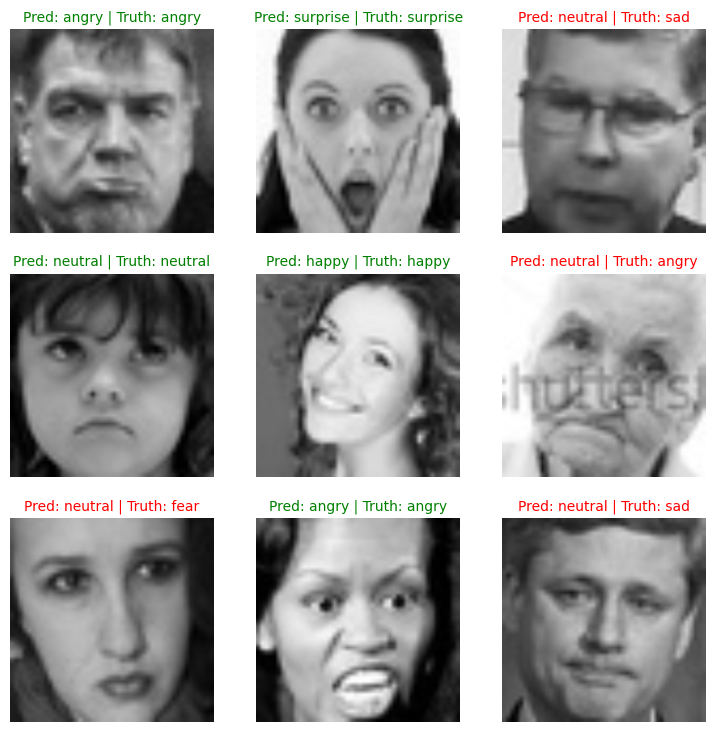

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device) -> torch.Tensor:

    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)


def show_predictions(model: torch.nn.Module,
                     device: torch.device,
                     val_data: datasets) -> None:

    val_samples = []
    val_labels = []

    for sample, label in random.sample(list(val_data), k=9):
        val_samples.append(sample)
        val_labels.append(label)

    pred_probs = make_predictions(
        model=model,
        data=val_samples,
        device=device
    )

    pred_classes = pred_probs.argmax(dim=1)
    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3

    for i, sample in enumerate(val_samples):
        plt.subplot(nrows, ncols, i+1)
        image = sample.squeeze().permute(1, 2, 0)
        plt.imshow(image)
        pred_label = val_data.classes[pred_classes[i]]
        truth_label = val_data.classes[val_labels[i]]
        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, c="g")
        else:
            plt.title(title_text, fontsize=10, c="r")
        plt.axis(False)


show_predictions(
    model=model,
    val_data=val_data,
    device=device)

In [ ]:
val_data

# 2. Train YOLOv5 to detect faces

In [67]:
def extract_data(zipfile_path: Path, im: Path) -> None:
    '''Extracts zipfile'''

    if images_path.is_dir():
        print(f"{images_path} exists.")
    else:
        print(f"{images_path} doesn't exist, creating one...")
        images_path.mkdir(parents=True, exist_ok=True)

    if not os.listdir(images_path):
        with ZipFile(zipfile_path, 'r') as zip:
            print("Extracting files...")
            zip.extractall(images_path)

            print("Extracting finished.")
    else:
        print("Data already extracted.")

zipfile_path = Path("/content/drive/MyDrive/face emo dataset/Humans.zip")
images_path = Path("/content/drive/MyDrive/face emo dataset/human faces")

extract_data(zipfile_path, images_path)

/content/drive/MyDrive/face emo dataset/human faces exists.
Data already extracted.


In [68]:
from pathlib import Path

data_path = Path("/content/drive/MyDrive/face emo dataset")
zipfile_path = data_path / "humans with label.zip"
images_path = data_path / "human faces"
annotations_path = data_path

In [69]:
from pathlib import Path
from zipfile import ZipFile

def extract_data(zipfile_path, images_path):
    '''Extracts zipfile'''

    # Check if the zip file already exists
    if not zipfile_path.exists():
        with ZipFile(zipfile_path, 'r') as zip_ref:
            zip_ref.extractall(images_path)
        print(f"Extraction complete: {zipfile_path} -> {images_path}")
    else:
        print(f"Zip file already exists: {zipfile_path}")

# Example usage:
data_path = Path("/content/drive/MyDrive/face emo dataset")
zipfile_path = data_path / "Humans.zip"
images_path = data_path / "human faces"
annotations_path = data_path

extract_data(zipfile_path, images_path)


Zip file already exists: /content/drive/MyDrive/face emo dataset/Humans.zip


-------------

## 2.1. Get the data

### Print some random images and draw bounding boxes to see if they are correct

In [110]:
zipfile_path = data_path / "/content/drive/MyDrive/face emo dataset/archive.zip"
images_path = data_path / "/content/drive/MyDrive/face emo dataset/human faces/Data/Images"
annotations_path=data_path / "/content/drive/MyDrive/face emo dataset/yolov5"

extract_data(zipfile_path, images_path)

Zip file already exists: /content/drive/MyDrive/face emo dataset/archive.zip


In [111]:
def print_random_images(photos: list, n: int = 5, seed=None) -> None:
    if n > 10:
        n=10

    if seed:
        rnd.seed(seed)

    for im in range(n):

        random_photo = random.choice(photos)
        random_photo_path = str(images_path) + '/' + str(random_photo)

        with Image.open(random_photo_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)
            ax.axis(False)
            image_width, image_height = fd.size

        file=random_photo[:random_photo.index(".")] + '.txt'
        annotation_file = annotations_path / file

        with open(annotation_file) as f:
            label = f.read()

        labels = label.split(" ")
        labels[4] = labels[4][:-1]
        labels = list(map(float, labels))

        x1, y1, width, height=labels[1:]
        bbox_x = x1*image_width-image_width*width/2
        bbox_y = y1*image_height-image_height*height/2
        bbox_width=width*image_width
        bbox_height=height*image_height

        mpatch=mpatches.Rectangle((bbox_x, bbox_y), bbox_width, bbox_height, linewidth=1, edgecolor='b', facecolor="none", lw=2)
        ax.add_patch(mpatch)
        rx, ry = mpatch.get_xy()
        ax.annotate('face', (rx, ry-2), color='blue', weight='bold', fontsize=12, ha='left', va='baseline')

photos_list = [f for f in listdir(images_path) if isfile(join(images_path, f))]
print_random_images(photos_list)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/face emo dataset/yolov5/1865.txt'

## 2.2. Use the splitfolders library to split data between training and validations sets

In [88]:
input_folder = Path("/content/drive/MyDrive/face emo dataset/human faces/Data")
output_folder = Path("/content/drive/MyDrive/face emo dataset/yolov5")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

Copying files: 1582 files [00:28, 56.23 files/s]

Moving files finished.


In [89]:
with open("/content/drive/MyDrive/face emo dataset/human faces/classes.txt") as f:
    classes = [classname.rstrip() for classname in f]

classes

['dog',
 'person',
 'cat',
 'tv',
 'car',
 'meatballs',
 'marinara sauce',
 'tomato soup',
 'chicken noodle soup',
 'french onion soup',
 'chicken breast',
 'ribs',
 'pulled pork',
 'hamburger',
 'cavity',
 'face']

In [84]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} files in '{dirpath}' folder ")

walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

There are 1 directiories and 1 files in '/content/drive/MyDrive/face emo dataset/human faces' folder 
There are 2 directiories and 0 files in '/content/drive/MyDrive/face emo dataset/human faces/Data' folder 
There are 0 directiories and 791 files in '/content/drive/MyDrive/face emo dataset/human faces/Data/Images' folder 
There are 0 directiories and 791 files in '/content/drive/MyDrive/face emo dataset/human faces/Data/Labels' folder 

There are 2 directiories and 0 files in '/content/drive/MyDrive/face emo dataset/yolov5 faces detection' folder 
There are 1 directiories and 0 files in '/content/drive/MyDrive/face emo dataset/yolov5 faces detection/train' folder 
There are 0 directiories and 0 files in '/content/drive/MyDrive/face emo dataset/yolov5 faces detection/train/Data' folder 
There are 1 directiories and 0 files in '/content/drive/MyDrive/face emo dataset/yolov5 faces detection/val' folder 
There are 0 directiories and 0 files in '/content/drive/MyDrive/face emo dataset/yolo

## 2.3. Create yolo config .yaml file

In [90]:
yaml_file = '/content/drive/MyDrive/face emo dataset/yolov5.yaml'

yaml_data = dict(
    path = "data/Faces_detection",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

In [ ]:
device_yolo = '0' if torch.cuda.is_available() else 'cpu'
device_yolo

## 2.4. Train YOLO!

In [91]:
start_time = timer()

!cd yolov5 && python train.py --workers 2 --img 640 --batch 16 --epochs 50 --data "data/faces.yaml" --weights yolov5s.pt --device {device_yolo} --cache

end_time = timer()

print(f'Training time: {(end_time-start_time):.2f}')

/bin/bash: line 1: cd: yolov5: No such file or directory
Training time: 0.11


# 3. Validate the results

## 3.1. Load yolo model

In [94]:
pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [98]:
import torch

model = torch.hub.load('ultralytics/yolov5:master', 'yolov5s', pretrained=True)



Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-1-31 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 126MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [103]:
import os
os.chdir('/content/drive/MyDrive/face emo dataset/yolov5')



In [108]:
model_yolo = torch.hub.load('ultralytics/yolov5', 'custom', path = '/content/drive/MyDrive/face emo dataset/yolov5/train/Images', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-1-31 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)



Exception: [Errno 2] No such file or directory: '/content/drive/MyDrive/face emo dataset/yolov5 faces detection/val/Data.pt'. Cache may be out of date, try `force_reload=True` or see https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading for help.

## 3.2. Create video loop

In [112]:
import cv2
import tensorflow as tf

video = "kaggle/CV/Emotions_detection/Sample_video.mp4"
#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(video)

## Create transform for images detected by yolo
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

assert cap.isOpened()

## video loop
while(cap.isOpened()):
    ret, frame = cap.read()
    assert not isinstance(frame,type(None)), 'frame not found'
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    results = model_yolo(frame)
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)

    labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
    width, height = frame.shape[1], frame.shape[0]

    for i in range(0, len(labels)):
        row = coordinates[i]
        if row[4] >= 0.4: ## if yolo detects face with prob > 0.4
            x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height) ## get x, y of the bbox
            face_crop = frame[int(y1):int(y2), int(x1):int(x2)] ## crop the face

            transformed_image = (test_transform(face_crop)).unsqueeze_(0) ## create the transform of cropped imgae
            model = model.to(torch.device(device)) ## send model to device
            transformed_image = transformed_image.to(torch.device(device)) ## send data to device

            pred_label = torch.max(model(transformed_image), 1) ## get pred label
            pred_class = val_data.classes[pred_label.indices.item()] ## get pred class

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) ## create bbox rectangle
            cv2.putText(frame, f"{pred_class}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3) ## create bbox text

    cv2.imshow('YOLO', frame) ## show frame

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

AssertionError: 